## Look at sample intersection

In [15]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import mpmp.config as cfg

In [16]:
# get sample list for each data type
# TODO: add mutation data?
sample_lists = {}
for training_data, sample_info_file in cfg.sample_infos.items():
    samples = pd.read_csv(sample_info_file, sep='\t', index_col=0).index
    sample_lists[training_data] = set(samples)
    
print('\n'.join(['{}\t{}'.format(n, '\t'.join(map(str, list(v)[:5])))
                  for n, v in sample_lists.items()]))

expression	TCGA-E1-5303-01	TCGA-XU-A92W-01	TCGA-50-6597-01	TCGA-AA-3664-01	TCGA-DU-7301-01
me_27k	TCGA-E1-5303-01	TCGA-XU-A92W-01	TCGA-50-6597-01	TCGA-AA-3664-01	TCGA-DU-7301-01
me_450k	TCGA-E1-5303-01	TCGA-XU-A92W-01	TCGA-50-6597-01	TCGA-DU-7301-01	TCGA-DA-A95Z-06
rppa	TCGA-E1-5303-01	TCGA-AA-3664-01	TCGA-50-6597-01	TCGA-DU-7301-01	TCGA-DA-A95Z-06


In [17]:
print('\n'.join(['{}\t{}'.format(n, len(v)) for n, v in sample_lists.items()]))

expression	11060
me_27k	11975
me_450k	9629
rppa	7790


Text(0.5, 1.0, 'Sample overlap between TCGA data types')

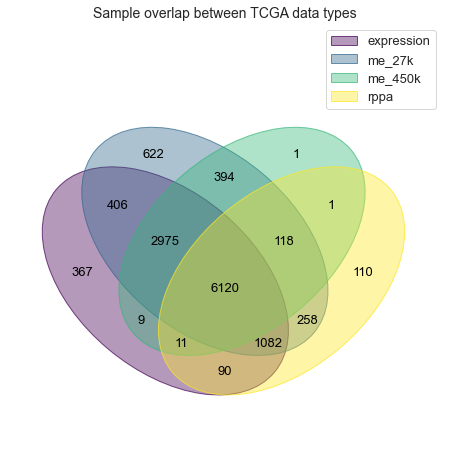

In [18]:
# do venn diagram
from venn import venn
sns.set_style('white')
venn(sample_lists)
plt.title('Sample overlap between TCGA data types', size=14)